In [3]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak


In [51]:
%load_ext autoreload
%autoreload 2

import os
import sys
import urllib.request
from collections import defaultdict

import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, RandomSampler
import torch.optim as optim

import torchvision
import torchvision.models as models
from torchvision.transforms import v2

from sklearn.datasets import load_svmlight_file

import matplotlib.pyplot as plt

from experiments import utils

from dotenv import load_dotenv
load_dotenv()

torch.set_default_dtype(torch.float64)
torch.set_num_threads(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
device = torch.device('cpu')
device

In [81]:
torch.random.manual_seed(0)
np.random.seed(0)

dataset_name = "a1a"
train_data, train_target, test_data, test_target = utils.get_libsvm(name=dataset_name, test_split=0.0)
L = (0.25 / train_data.shape[0]) * scipy.sparse.linalg.norm(train_data.T @ train_data, ord=2)


batch_size = train_data.shape[0]

train_target = utils.map_classes_to(train_target, [0, 1])
test_target = utils.map_classes_to(test_target, [0, 1])

train_data = torch.from_numpy(train_data.toarray()).to(torch.float64)
train_target = torch.from_numpy(train_target).to(torch.float64)

test_data = torch.from_numpy(test_data.toarray()).to(torch.float64)
test_target = torch.from_numpy(test_target).to(torch.float64)

in_features = train_data.shape[1]

train_dataloader = DataLoader(TensorDataset(train_data, train_target), 
                              batch_size=batch_size, 
                              shuffle=False)

test_dataloader = DataLoader(TensorDataset(test_data, test_target), 
                             batch_size=len(test_data), 
                             shuffle=False)

print(f"{train_data.shape=}")
print(f"{test_data.shape=}")
print("Sparsity: ", 1 - (train_data.count_nonzero() / (train_data.shape[0] * train_data.shape[1])))

train_data.shape=torch.Size([1605, 123])
test_data.shape=torch.Size([30956, 123])
Sparsity:  tensor(0.8873)


In [48]:
torch.unique(train_target), torch.unique(test_target)

(tensor([0., 1.]), tensor([0., 1.]))

In [58]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, prefix="val", suptitle=None, 
            threshold=1e-10, max_iters=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    
    for history, label, c, ls, lw, m in zip(histories, labels, colors, linestyles, linewidths, markers):
        loss = history["test/loss"]
        acc = history["test/acc"]
        
        markevery = [x + np.random.randint(0, 3) for x in range(0, len(loss), len(loss) // 10)]
        
        ax[0].semilogy(loss, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        ax[1].plot(acc, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m)

    ax[0].set_ylabel(r"$f(w_i)$")
    ax[1].set_ylabel("Accuracy")
        
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        fig.savefig(filename)
    else:
        fig.show() 

In [59]:
class LinearModel(nn.Module):
    def __init__(self, in_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, 1) 
    
    def forward(self, x):
        return self.linear(x).squeeze(1)

In [84]:
def train_loop(
    optimizer: optim.Optimizer,
    **optimizer_kwargs
):

    torch.manual_seed(0)

    model = LinearModel(in_features=in_features)

    optimizer = optimizer(model.parameters(), **optimizer_kwargs)
    criterion = nn.BCEWithLogitsLoss()

    hist = defaultdict(list)

    for i in range(200):

        model.eval()
        test_pred = model(test_data)
        test_pred = (test_pred > 0.5).float() 
        acc = (test_pred == test_target).float().mean() 
        loss = criterion(test_pred, test_target)
        
        hist["test/loss"].append(loss.item())
        hist["test/acc"].append(acc)
            
        model.train()
        optimizer.zero_grad()
        pred = model(train_data)
        loss = criterion(pred, train_target)
        loss.backward()
        optimizer.step()
        
    return hist

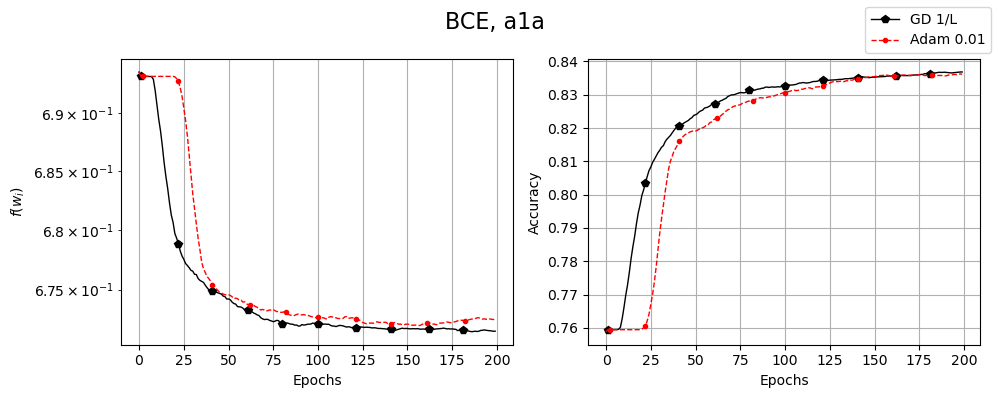

In [86]:
histories = []
labels = []

gd_hist = train_loop(optim.SGD, lr=1/L)
histories.append(gd_hist)
labels.append("GD 1/L")

adam_hist = train_loop(optim.Adam, lr=0.01)
histories.append(adam_hist)
labels.append("Adam 0.01")

plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=["p", ".", "v", "*", "d"],
        suptitle=f"BCE, {dataset_name}",
        threshold=0.0)